### This file can be used to compare the spectrograms for the times in the selection window.

The code takes in the numpy array from the file new.npy. This array represents the output of the given by the spectrogram function in vggish_input. The code then extracts all the time stamps from the selection table. It then uses the matplotlib offsetBox to cluster similar spectrograms together and the ones that are different to another side.

Note - for this file to run, no changes have been made to the vggish_model.

In [19]:
import tensorflow as tf
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt

In [20]:
# the following code loads the 3d numpy array output that we get from the 
# file vggish_input.py 
# the shape of this array is [num_examples, num_frames, num_bands]
vggish_output_array = np.load('new.npy') # the bigger array

In [21]:
vggish_output_array.shape

(633, 96, 64)

In [22]:
l = vggish_output_array.shape
observations = l[0]
# represents the 96 frames that divide one window. 
timeStamps = l[1]
freq = l[2]

In [23]:
# Making the array that we need to work with
vggish_reshape_array = np.reshape(vggish_output_array, (observations * timeStamps, freq))
vggish_transpose_array = vggish_reshape_array.T
print(vggish_transpose_array.shape)

(64, 60768)


In [24]:
# function to read the file and get all the times of the observed activities

# Note - there is no need to read the output file in this way. Simply use the table method of pandas.  

# code to store all the times in an array 
filepath = 'selection_table.txt'
times = []
with open(filepath) as fp:
   line_read = fp.readline()
   cnt = 1
   while (line_read ):
       temp = fp.readline().split()
       if(len(temp) == 0): 
           break 
       times.append(temp[4]); 
       cnt += 1

In [25]:
# the thing that I need to plot
# the following function takes in two inputs 
# 1. times - the array that stores all the times from the selection table 
# 2. input_array - the transposed and reshaped array that we receive from the vggish_input file. 

def spectrogram_data_storage_helper_function(times, input_array):
    
    result = []
    for time in times:
        time_to_see = float(time) / 1000 #to convert to seconds 
        freqs_to_see = float(time) / 10
        
        bound1 = int(freqs_to_see - 10)
        bound2 = int(freqs_to_see + 10)

        result.append(input_array[:, bound1: bound2])
        # returns the array that has data for the spectrograms 
    return result

In [26]:
# this represents the data that needs to be plotted using matplotlib offsetbox
plotting_data = spectrogram_data_storage_helper_function(times, vggish_transpose_array)

In [28]:
# reading the contents of the tf records that we get as output for the 
# vggish_inference_demo.py.

# NOTE - In order to get these we need to have 64 mel bins instead of the 512 that we were using because the use
# 64 in the vggish_slim module. The program still runs with the updated

tfrecords_filename = 'new_changes_parameters.tfrecord'
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
string_record = next(record_iterator)
example = tf.train.SequenceExample()
example.ParseFromString(string_record)

f = example.feature_lists.feature_list['audio_embedding']

hexembed = f.feature[59].bytes_list.value[0].hex()

vggish_embed = [int(hexembed[i:i+2],16) for i in range(0,len(hexembed),2)]

In [29]:
len(vggish_embed) 

128

In [30]:
# earlier we had just 60 cases but now we have more but for now we are just taking the first 60
tf_records_array = []
for x in range(0, 633):
    temp = f.feature[x].bytes_list.value[0].hex()
    tf_records_array.append([int(temp[i:i+2],16) for i in range(0,len(temp),2)])

In [31]:
tf_records_array = np.array(tf_records_array)
tf_records_array.shape

(633, 128)

In [32]:
# doing PCA decomposition of the numpy array answer 
pca = decomposition.PCA()
pca.fit(tf_records_array)
print(pca)

# applying dimentionaly reduction to that array 
transformed_data = pca.transform(tf_records_array)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [33]:
# selecting all the rows for the first 2 columns 
# here colum 2 is not selected and only 0, 1 colum is selected 
# we are selecting only 2 columns becasue we need to plot the data on a 2d graph. 

X_transformed = transformed_data[:,0:2]

In [34]:
from matplotlib import offsetbox

def plot_embedding(X_transformed, X, title=None, y = None):
    x_min, x_max = np.min(X_transformed, 0), np.max(X_transformed, 0)
    X_transformed = (X_transformed - x_min) / (x_max - x_min)
    
    
    # this is the main plot that is being plotted
    plt.figure(figsize=(15,15))
    
    # creating subplots of all the iimages that need to be positioned
    ax = plt.subplot(111)
    for i in range(X_transformed.shape[0]):
        
        # the following if condition is to give the plot a title in this case we are giving it 'o'
        if y is None:
            plt.text(X_transformed[i, 0], X_transformed[i, 1], str("o"),
                     fontdict={'weight': 'bold', 'size': 9})
        else:
            plt.text(X_transformed[i, 0], X_transformed[i, 1], str(y[i]),
                     color=plt.cm.Set1(y[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})
            

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_transformed.shape[0]):
            dist = np.sum((X_transformed[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_transformed[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i, :, :].T, cmap=plt.cm.gray_r),
                X_transformed[i])
            # addinig the images to the ax or the subplots created for the main matplotlib
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

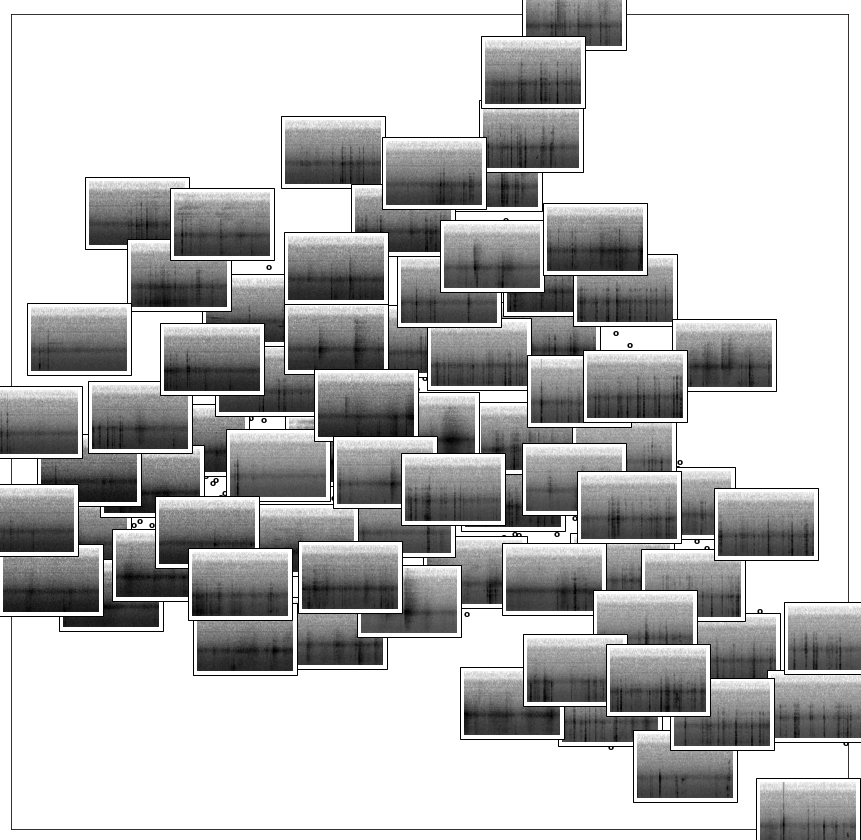

In [35]:
# clearly this plot is different from the one that was plotted earlier without changing the parameters and 
plot_embedding(X_transformed, specs)

## Observations - 
The individual plots are darker as they now have more higher frequency. 
For me to just plot the data images that i already produce i need to plot it using kmeans. 

The above code clusters all the spectrograms(633 in total) of 0.96 seconds each in the matplotlib offsetbox.

## Now - 
The code that follows only plots the grahps that are in the selection table. I tried to make the window size a little smaller but there is no way that the vggish_inference_demo produces results smaller than the 0.96 windows.

### Further Steps - Later I solved this problem by changing the individual window size of the spectrograms. So instead of 0.96 the windows represented 0.24 seconds. 

In [36]:
# reading the contents of the tf records that we get as output for the 
# vggish_inference_demo.py.

# NOTE - In order to get these we need to have 64 mel bins instead of the 512 that we were using because the use
# 64 in the vggiish_sliim module. The program still runs with the updated
tfrecords_filename = 'new_changes_parameters.tfrecord'
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
string_record = next(record_iterator)
example = tf.train.SequenceExample()
example.ParseFromString(string_record)

f = example.feature_lists.feature_list['audio_embedding']

hexembed = f.feature[59].bytes_list.value[0].hex()

vggish_embed = [int(hexembed[i:i+2],16) for i in range(0,len(hexembed),2)]

In [37]:
# earlier we had just 60 cases but now we have more but for now we are just taking the first 60
tf_records_array = []
for x in range(0, 633):
    temp = f.feature[x].bytes_list.value[0].hex()
    tf_records_array.append([int(temp[i:i+2],16) for i in range(0,len(temp),2)])

In [38]:
# The following numpy array stores the 128 features of the 633 spectrograms made by the vggish model. 
tf_records_array = np.array(tf_records_array)
tf_records_array.shape

(633, 128)

In [39]:
# selecting only the spectrograms that have been listed in the selection table. But plotting the 0.96 sec window
# insead of the smaller windows to make clustering better. 
plotting_tf_records = [tf_records_array[int(float(time) / 0.96)] for time in times]

plotting_tf_records = np.array(plotting_tf_records)

In [40]:
plotting_tf_records.shape

(11, 128)

In [41]:
# doing PCA decomposition of the numpy array answer 
pca = decomposition.PCA()
pca.fit(plotting_tf_records)
print(pca)

# applying dimentionaly reduction to that array 
transformed_data = pca.transform(plotting_tf_records)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [42]:
# selecting all the rows for the first 2 columns 
# here column 2 is not selected and only 0, 1 column is selected 
# We are selecting only 2 columns because we need to plot the data on a 2d graph. 

X_transformed = transformed_data[:,0:2]

In [43]:
# selecting only the spectrogams that have the 
plotting_spectrograms = [specs[int(float(time) / 0.96), :, :] for time in times]
plotting_spectrograms = np.array(plotting_spectrograms)

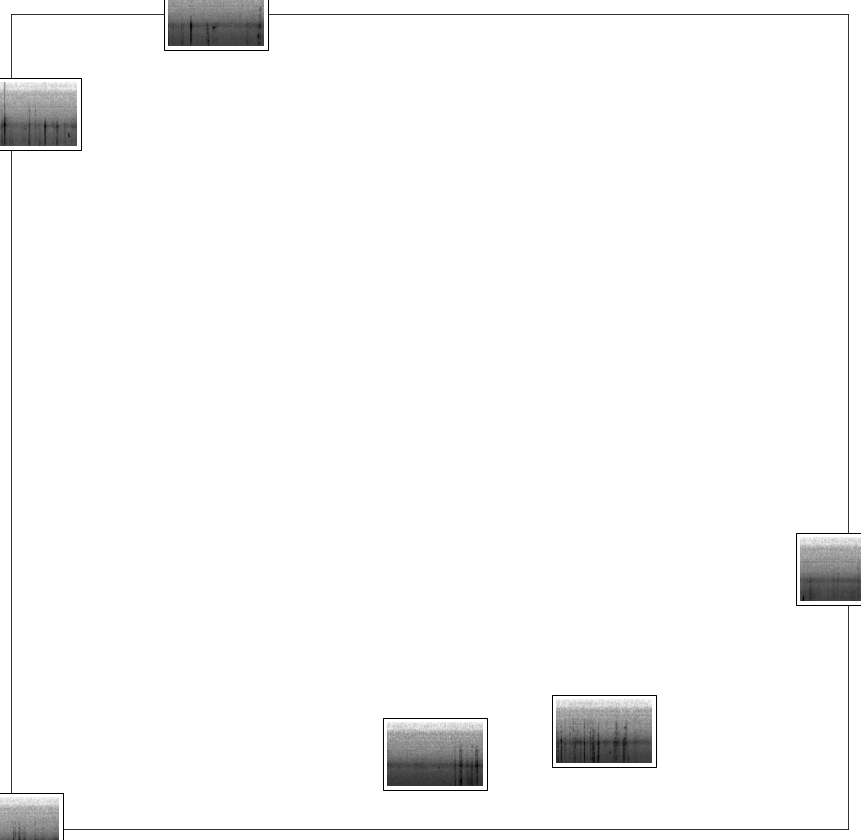

In [44]:
plot_embedding(X_transformed, plotting_spectrograms)